In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/2357gi/Sandbox/signatej/venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


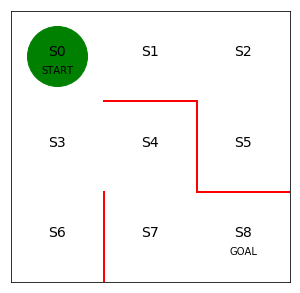

In [2]:
# 初期状態での迷路の様子_

# 図を描く大きさと、図の変数を宣言。
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# make wall
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# make points
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 描画範囲の設定とメモリを消す設定
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 現在地に丸を描画する。
line, = ax.plot([0.5], [2.5], 'o', color = 'g', markersize=60)

In [3]:
# 初期の方策を決定するparams theta_0を設定

# 行は0~7, 列は移動方向で上右下左を表す。
theta_0 = np.array([[np.nan, 1, 1, np.nan],  
                   [np.nan, 1, np.nan, 1],
                    [np.nan, np.nan, 1, 1],
                   [1, 1, 1, np.nan],        
                   [np.nan, np.nan, 1, 1],   
                   [1, np.nan, np.nan, np.nan],  
                   [1, np.nan, np.nan, np.nan],  
                   [1, 1, np.nan, np.nan],       
                    ])

# 方策反復法の実装
強化学習の方策反復法を実装する。
ランダムで移動する方策を実装したが、ここからエージェントが一直線にゴールへ移動するために考える。
方策に従って行動しゴールした時に、早くゴールできたケースで実行した行動(action)は重要だと考え、その行動を多く取り入れるようにする方策を更新する作戦。
->**方策反復法**

### 方策を求める方法を変更する
今まではθを割合に変換し、方策としていた。
今回はソフトマックス関数を使用する。
$$
P(θ_i) = {\frac{exp(βθ_i)}{{\sum_(j=1)^(N_a)}exp(βθ_j)}}
$$
ソフトマックス関数は逆温度βが小さいほど行動がよりランダムになるという性質がある。

In [4]:
def softmax_convert_into_pi_from_theta(theta):
    
    beta = 1.0
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    
    exp_theta = np.exp(beta * theta)
    
    for i in range(0, m):
        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
    
    # pi = np.nan_to_sum(pi)
    pi = np.where( np.isnan(pi),0,pi)
    
    return pi

In [5]:
pi_0 = softmax_convert_into_pi_from_theta(theta_0)

In [6]:
pi_0

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ]])

### 方策に従ってエージェントを移動させる関数
今回はどの行動が有効だったかをフィードバックするために、
どの行動をとったかを示すactionを用意する。

In [7]:
def get_action_and_next_s(pi, s):
    direction = ['up', 'right', 'down', 'left']
    next_direction = np.random.choice(direction, p=pi[s, :])
    
    if next_direction == 'up':
        action = 0
        s_next = s - 3
    elif next_direction == 'right':
        action = 1
        s_next = s + 1
    elif next_direction == 'down':
        action = 2
        s_next = s + 3
    elif next_direction == 'left':
        action = 3
        s_next = s - 1
    
    return [action, s_next]

In [8]:
def goal_maze_ret_s_a(pi):
    s = 0
    s_a_history = [[0, np.nan]]
    
    while (1):  # ゴールするまでループ
        [action, next_s] = get_action_and_next_s(pi, s)
        s_a_history[-1][1] = action  # 現在の状況を入力。一番最後に撮った行動なので[-1]
        
        s_a_history.append([next_s, np.nan])
        
        if next_s == 8:
            break
        else:
            s = next_s
            
    return s_a_history

In [9]:
s_a_history = goal_maze_ret_s_a(pi_0)
print(s_a_history)
print('迷路を解くのにかかったステップ数は' + str(len(s_a_history) - 1) + 'です。')

[[0, 1], [1, 1], [2, 3], [1, 3], [0, 1], [1, 3], [0, 2], [3, 1], [4, 3], [3, 1], [4, 2], [7, 0], [4, 2], [7, 0], [4, 3], [3, 0], [0, 1], [1, 1], [2, 3], [1, 3], [0, 1], [1, 1], [2, 3], [1, 3], [0, 2], [3, 2], [6, 0], [3, 0], [0, 1], [1, 3], [0, 2], [3, 2], [6, 0], [3, 0], [0, 2], [3, 0], [0, 2], [3, 0], [0, 1], [1, 1], [2, 3], [1, 3], [0, 2], [3, 1], [4, 2], [7, 0], [4, 3], [3, 2], [6, 0], [3, 1], [4, 2], [7, 1], [8, nan]]
迷路を解くのにかかったステップ数は52です。


In [10]:
s_a_history[1]

[1, 1]

In [11]:
from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([],[])
    return (line,)

def animate(i):
    state = s_a_history[i][0] # 現在の座標を描く
    x = (state %3) + 0.5
    y = 2.5 - int(state / 3)
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history),
                              interval=200, repeat=True)

HTML(anim.to_jshtml())

# 方策勾配法に従い方策を更新
方策勾配法に従い方策を更新する。
$$
θ_{s_i,a_i} = θ_{s_i,a_j} + n
$$

In [12]:
def update_theta(theta, pi, s_a_history):
    eta = 0.1  # 学習率
    T = len(s_a_history) - 1
    
    [m, n] = theta.shape
    delta_theta = theta.copy()  # Δthetaの元を作成。numpyはCでできていて、ポインタを実装しているので = だとどうメモリを参照してしまう。
    
    # delta_thetaを要素ごとに求める
    for i in range(0, m):
        for j in range(0, n):
            if not(np.isnan(theta[i, j])):  # thetaがnanでない場合
                
                SA_i = [SA for SA in s_a_history if SA[0] == i]
                # 履歴からiのものを取り出す内包表記
                
                SA_ij = [SA for SA in s_a_history if SA == [i, j]]
                # 履歴からi, jのものを取り出す内包表記
                
                N_i = len(SA_i) # 状態iで行動した総回数
                N_ij = len(SA_ij) # 状態ijで行動した総回数
                
                delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T
    
    net_theta = theta + eta * delta_theta
    
    return net_theta
                
    

In [13]:
new_theta = update_theta(theta_0, pi_0, s_a_history)
pi = softmax_convert_into_pi_from_theta(new_theta)
print(pi)

[[0.         0.5        0.5        0.        ]
 [0.         0.49903846 0.         0.50096154]
 [0.         0.         0.49807693 0.50192307]
 [0.33397456 0.33333292 0.33269251 0.        ]
 [0.         0.         0.50048077 0.49951923]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.50096154 0.49903846 0.         0.        ]]


## 探索とパラメータの更新を規定値まで繰り返すプログラム

In [14]:
step_epsilon = 10**-4  # 10^-4よりもパラメータの変化の値が小さくなったら更新を終了する。

theta = theta_0
pi = pi_0

is_continue = True
count = 1
while is_continue:
    s_a_history = goal_maze_ret_s_a(pi)  # 方策piで迷路内を探索したログを収める。
    new_theta = update_theta(theta, pi, s_a_history)
    new_pi = softmax_convert_into_pi_from_theta(new_theta)
    
    print(np.sum(np.abs(new_pi - pi)))  # 方策の変化を出力
    print('試行' + str(count) + '回目で、迷路を解くまでにかかったStep数は' + str(len(s_a_history) - 1) + 'です。')
    
    
    if np.sum(np.sum(np.abs(new_pi - pi))) < step_epsilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi
        count += 1

0.012644167358614455
試行1回目で、迷路を解くまでにかかったStep数は40です。
0.014874185710014087
試行2回目で、迷路を解くまでにかかったStep数は60です。
0.005679582830194263
試行3回目で、迷路を解くまでにかかったStep数は98です。
0.014750851831095091
試行4回目で、迷路を解くまでにかかったStep数は46です。
0.006062814699465402
試行5回目で、迷路を解くまでにかかったStep数は50です。
0.041282640298676676
試行6回目で、迷路を解くまでにかかったStep数は12です。
0.022301071456398425
試行7回目で、迷路を解くまでにかかったStep数は22です。
0.024520343176509862
試行8回目で、迷路を解くまでにかかったStep数は10です。
0.015658350421932143
試行9回目で、迷路を解くまでにかかったStep数は26です。
0.015481343365098932
試行10回目で、迷路を解くまでにかかったStep数は30です。
0.00415324484907742
試行11回目で、迷路を解くまでにかかったStep数は96です。
0.012144675378407743
試行12回目で、迷路を解くまでにかかったStep数は36です。
0.002818477848325174
試行13回目で、迷路を解くまでにかかったStep数は62です。
0.01375186624382696
試行14回目で、迷路を解くまでにかかったStep数は64です。
0.01506547808537867
試行15回目で、迷路を解くまでにかかったStep数は40です。
0.008354003220780781
試行16回目で、迷路を解くまでにかかったStep数は126です。
0.010910246037251325
試行17回目で、迷路を解くまでにかかったStep数は48です。
0.010885135665572754
試行18回目で、迷路を解くまでにかかったStep数は64です。
0.011886174387811421
試行19回目で、迷路を解くまでにかかったStep数は50です。
0.04

試行269回目で、迷路を解くまでにかかったStep数は18です。
0.020915741013635802
試行270回目で、迷路を解くまでにかかったStep数は14です。
0.020767989353064648
試行271回目で、迷路を解くまでにかかったStep数は4です。
0.018829647861252186
試行272回目で、迷路を解くまでにかかったStep数は14です。
0.021083726094149602
試行273回目で、迷路を解くまでにかかったStep数は14です。
0.011446708262355831
試行274回目で、迷路を解くまでにかかったStep数は10です。
0.020481774530121483
試行275回目で、迷路を解くまでにかかったStep数は4です。
0.018830803547137703
試行276回目で、迷路を解くまでにかかったStep数は22です。
0.015414537422846375
試行277回目で、迷路を解くまでにかかったStep数は6です。
0.020217906747639847
試行278回目で、迷路を解くまでにかかったStep数は4です。
0.019934521188599952
試行279回目で、迷路を解くまでにかかったStep数は4です。
0.012829802785249617
試行280回目で、迷路を解くまでにかかったStep数は6です。
0.01722912192253695
試行281回目で、迷路を解くまでにかかったStep数は18です。
0.019699192398338422
試行282回目で、迷路を解くまでにかかったStep数は4です。
0.019425279190999817
試行283回目で、迷路を解くまでにかかったStep数は4です。
0.012727310228056732
試行284回目で、迷路を解くまでにかかったStep数は8です。
0.012528412748671724
試行285回目で、迷路を解くまでにかかったStep数は6です。
0.019933052669068363
試行286回目で、迷路を解くまでにかかったStep数は18です。
0.012432995954931636
試行287回目で、迷路を解くまでにかかったStep数は6です。
0.01441

0.007282537645746545
試行511回目で、迷路を解くまでにかかったStep数は4です。
0.0075285025037942765
試行512回目で、迷路を解くまでにかかったStep数は6です。
0.007227089166426559
試行513回目で、迷路を解くまでにかかったStep数は4です。
0.0071486987661182055
試行514回目で、迷路を解くまでにかかったStep数は4です。
0.007071462709661941
試行515回目で、迷路を解くまでにかかったStep数は4です。
0.01080610023123263
試行516回目で、迷路を解くまでにかかったStep数は6です。
0.006966329886555017
試行517回目で、迷路を解くまでにかかったStep数は4です。
0.009539937467826373
試行518回目で、迷路を解くまでにかかったStep数は8です。
0.008310570025612252
試行519回目で、迷路を解くまでにかかったStep数は6です。
0.00699160750826007
試行520回目で、迷路を解くまでにかかったStep数は4です。
0.006916693615726971
試行521回目で、迷路を解くまでにかかったStep数は4です。
0.006842872804879968
試行522回目で、迷路を解くまでにかかったStep数は4です。
0.0067701261648679956
試行523回目で、迷路を解くまでにかかったStep数は4です。
0.006698435128949978
試行524回目で、迷路を解くまでにかかったStep数は4です。
0.013043194800077318
試行525回目で、迷路を解くまでにかかったStep数は10です。
0.00737663015962807
試行526回目で、迷路を解くまでにかかったStep数は6です。
0.016122128412034822
試行527回目で、迷路を解くまでにかかったStep数は6です。
0.014992259408884337
試行528回目で、迷路を解くまでにかかったStep数は10です。
0.015119616626436377
試行529回目で、迷路を解くまでにかかったSt

0.003580595339954293
試行772回目で、迷路を解くまでにかかったStep数は4です。
0.007146352755257976
試行773回目で、迷路を解くまでにかかったStep数は6です。
0.003554944422301587
試行774回目で、迷路を解くまでにかかったStep数は4です。
0.0035258610757231273
試行775回目で、迷路を解くまでにかかったStep数は4です。
0.0034971177769238387
試行776回目で、迷路を解くまでにかかったStep数は4です。
0.0034687094874053664
試行777回目で、迷路を解くまでにかかったStep数は4です。
0.003440631256642776
試行778回目で、迷路を解くまでにかかったStep数は4です。
0.00587290691227757
試行779回目で、迷路を解くまでにかかったStep数は6です。
0.012660451760533376
試行780回目で、迷路を解くまでにかかったStep数は6です。
0.005915793460461852
試行781回目で、迷路を解くまでにかかったStep数は6です。
0.008808028589810252
試行782回目で、迷路を解くまでにかかったStep数は12です。
0.0035528861856327087
試行783回目で、迷路を解くまでにかかったStep数は4です。
0.0035237994696576264
試行784回目で、迷路を解くまでにかかったStep数は4です。
0.007101280583285574
試行785回目で、迷路を解くまでにかかったStep数は6です。
0.0076501950271916225
試行786回目で、迷路を解くまでにかかったStep数は10です。
0.0035568401644505976
試行787回目で、迷路を解くまでにかかったStep数は4です。
0.005981432126590469
試行788回目で、迷路を解くまでにかかったStep数は6です。
0.0035585458032415668
試行789回目で、迷路を解くまでにかかったStep数は4です。
0.0035294010648743712
試行790回目で、迷路を解くま

0.002174129945488032
試行1050回目で、迷路を解くまでにかかったStep数は4です。
0.0021592951441516406
試行1051回目で、迷路を解くまでにかかったStep数は4です。
0.0021446090010772342
試行1052回目で、迷路を解くまでにかかったStep数は4です。
0.0021300695884698337
試行1053回目で、迷路を解くまでにかかったStep数は4です。
0.002115675008508379
試行1054回目で、迷路を解くまでにかかったStep数は4です。
0.0021014233928211834
試行1055回目で、迷路を解くまでにかかったStep数は4です。
0.002087312901966322
試行1056回目で、迷路を解くまでにかかったStep数は4です。
0.005071195914473373
試行1057回目で、迷路を解くまでにかかったStep数は6です。
0.0020894279989423503
試行1058回目で、迷路を解くまでにかかったStep数は4です。
0.002075448355434717
試行1059回目で、迷路を解くまでにかかったStep数は4です。
0.002061606199847979
試行1060回目で、迷路を解くまでにかかったStep数は4です。
0.00508775900090689
試行1061回目で、迷路を解くまでにかかったStep数は6です。
0.0020649434618458737
試行1062回目で、迷路を解くまでにかかったStep数は4です。
0.0020512119826043076
試行1063回目で、迷路を解くまでにかかったStep数は4です。
0.002037614731124175
試行1064回目で、迷路を解くまでにかかったStep数は4です。
0.0020241500049937577
試行1065回目で、迷路を解くまでにかかったStep数は4です。
0.010470662608654709
試行1066回目で、迷路を解くまでにかかったStep数は6です。
0.0020167152513911185
試行1067回目で、迷路を解くまでにかかったStep数は4です。
0.002003493099829896

0.001052128437641374
試行1372回目で、迷路を解くまでにかかったStep数は4です。
0.0010470388233521158
試行1373回目で、迷路を解くまでにかかったStep数は4です。
0.0010419859927419603
試行1374回目で、迷路を解くまでにかかったStep数は4です。
0.0010369695935882675
試行1375回目で、迷路を解くまでにかかったStep数は4です。
0.008909026590376429
試行1376回目で、迷路を解くまでにかかったStep数は6です。
0.0034314882041983144
試行1377回目で、迷路を解くまでにかかったStep数は6です。
0.0010428164823264377
試行1378回目で、迷路を解くまでにかかったStep数は4です。
0.0010378243280750807
試行1379回目で、迷路を解くまでにかかったStep数は4です。
0.0010328677947817957
試行1380回目で、迷路を解くまでにかかったStep数は4です。
0.0010279465461064188
試行1381回目で、迷路を解くまでにかかったStep数は4です。
0.0010230602496386076
試行1382回目で、迷路を解くまでにかかったStep数は4です。
0.0010182085768404708
試行1383回目で、迷路を解くまでにかかったStep数は4です。
0.0010133912029962819
試行1384回目で、迷路を解くまでにかかったStep数は4です。
0.003413603478711856
試行1385回目で、迷路を解くまでにかかったStep数は6です。
0.0010179107646231325
試行1386回目で、迷路を解くまでにかかったStep数は4です。
0.0036972109371857242
試行1387回目で、迷路を解くまでにかかったStep数は6です。
0.0010290696458491802
試行1388回目で、迷路を解くまでにかかったStep数は4です。
0.0010241637150968722
試行1389回目で、迷路を解くまでにかかったStep数は4です。
0.00101929267

試行1697回目で、迷路を解くまでにかかったStep数は6です。
0.0005392264307148911
試行1698回目で、迷路を解くまでにかかったStep数は4です。
0.0005373415096138756
試行1699回目で、迷路を解くまでにかかったStep数は4です。
0.0005354664698813648
試行1700回目で、迷路を解くまでにかかったStep数は4です。
0.0005336012425276836
試行1701回目で、迷路を解くまでにかかったStep数は4です。
0.007549010770888282
試行1702回目で、迷路を解くまでにかかったStep数は8です。
0.0005414869712302775
試行1703回目で、迷路を解くまでにかかったStep数は4です。
0.0005395907092472646
試行1704回目で、迷路を解くまでにかかったStep数は4です。
0.0005377044101171242
試行1705回目で、迷路を解くまでにかかったStep数は4です。
0.0005358280040876906
試行1706回目で、迷路を解くまでにかかったStep数は4です。
0.0005339614220143118
試行1707回目で、迷路を解くまでにかかったStep数は4です。
0.0005321045953578275
試行1708回目で、迷路を解くまでにかかったStep数は4です。
0.0005302574561737751
試行1709回目で、迷路を解くまでにかかったStep数は4です。
0.0005284199371086533
試行1710回目で、迷路を解くまでにかかったStep数は4です。
0.0005265919713919182
試行1711回目で、迷路を解くまでにかかったStep数は4です。
0.007541044990692955
試行1712回目で、迷路を解くまでにかかったStep数は8です。
0.0005347872021939856
試行1713回目で、迷路を解くまでにかかったStep数は4です。
0.0005329257363961282
試行1714回目で、迷路を解くまでにかかったStep数は4です。
0.0027266291663432286
試行1715回目で、迷路

0.00036532253291277766
試行2017回目で、迷路を解くまでにかかったStep数は4です。
0.0003642541139604605
試行2018回目で、迷路を解くまでにかかったStep数は4です。
0.002194622445985679
試行2019回目で、迷路を解くまでにかかったStep数は6です。
0.002237452994231559
試行2020回目で、迷路を解くまでにかかったStep数は6です。
0.00037694146464396436
試行2021回目で、迷路を解くまでにかかったStep数は4です。
0.0003758117112807255
試行2022回目で、迷路を解くまでにかかったStep数は4です。
0.0003746871167121281
試行2023回目で、迷路を解くまでにかかったStep数は4です。
0.000373567649118816
試行2024回目で、迷路を解くまでにかかったStep数は4です。
0.001966541238240551
試行2025回目で、迷路を解くまでにかかったStep数は6です。
0.00037559710857933484
試行2026回目で、迷路を解くまでにかかったStep数は4です。
0.00037447699252011676
試行2027回目で、迷路を解くまでにかかったStep数は4です。
0.00037336195613839676
試行2028回目で、迷路を解くまでにかかったStep数は4です。
0.00037225196836164487
試行2029回目で、迷路を解くまでにかかったStep数は4です。
0.0003711469983590024
試行2030回目で、迷路を解くまでにかかったStep数は4です。
0.0003700470155331842
試行2031回目で、迷路を解くまでにかかったStep数は4です。
0.0003689519895269111
試行2032回目で、迷路を解くまでにかかったStep数は4です。
0.0003678618902124009
試行2033回目で、迷路を解くまでにかかったStep数は4です。
0.00036677668769297816
試行2034回目で、迷路を解くまでにかかったStep数は4です。
0.00036

0.00027992125579703875
試行2337回目で、迷路を解くまでにかかったStep数は4です。
0.00027921257599265725
試行2338回目で、迷路を解くまでにかかったStep数は4です。
0.0016250195358549525
試行2339回目で、迷路を解くまでにかかったStep数は6です。
0.0002808633562195219
試行2340回目で、迷路を解くまでにかかったStep数は4です。
0.0002801530593733309
試行2341回目で、迷路を解くまでにかかったStep数は4です。
0.00027944546565238093
試行2342回目で、迷路を解くまでにかかったStep数は4です。
0.00027874056128286695
試行2343回目で、迷路を解くまでにかかったStep数は4です。
0.002504470327022359
試行2344回目で、迷路を解くまでにかかったStep数は8です。
0.00028421613246411986
試行2345回目で、迷路を解くまでにかかったStep数は4です。
0.0002834922278515395
試行2346回目で、迷路を解くまでにかかったStep数は4です。
0.0002827710995955135
試行2347回目で、迷路を解くまでにかかったStep数は4です。
0.0002820527334306301
試行2348回目で、迷路を解くまでにかかったStep数は4です。
0.0002813371151847571
試行2349回目で、迷路を解くまでにかかったStep数は4です。
0.00028062423077608936
試行2350回目で、迷路を解くまでにかかったStep数は4です。
0.0002799140662142485
試行2351回目で、迷路を解くまでにかかったStep数は4です。
0.00027920660759846866
試行2352回目で、迷路を解くまでにかかったStep数は4です。
0.000278501841116139
試行2353回目で、迷路を解くまでにかかったStep数は4です。
0.0002777997530452256
試行2354回目で、迷路を解くまでにかかったStep数は4です。
0.000

試行2696回目で、迷路を解くまでにかかったStep数は4です。
0.00021536008905559748
試行2697回目で、迷路を解くまでにかかったStep数は4です。
0.00021488223875201426
試行2698回目で、迷路を解くまでにかかったStep数は4です。
0.00021440598407988093
試行2699回目で、迷路を解くまでにかかったStep数は4です。
0.00021393131790524433
試行2700回目で、迷路を解くまでにかかったStep数は4です。
0.0002134582331362149
試行2701回目で、迷路を解くまでにかかったStep数は4です。
0.0002129867227191641
試行2702回目で、迷路を解くまでにかかったStep数は4です。
0.0015469277241839142
試行2703回目で、迷路を解くまでにかかったStep数は6です。
0.00021505591779610173
試行2704回目で、迷路を解くまでにかかったStep数は4です。
0.0002145796079285056
試行2705回目で、迷路を解くまでにかかったStep数は4です。
0.0002141048841536597
試行2706回目で、迷路を解くまでにかかったStep数は4です。
0.00021363173940728772
試行2707回目で、迷路を解くまでにかかったStep数は4です。
0.00021316016666514392
試行2708回目で、迷路を解くまでにかかったStep数は4です。
0.0002126901589428916
試行2709回目で、迷路を解くまでにかかったStep数は4です。
0.00021222170929466322
試行2710回目で、迷路を解くまでにかかったStep数は4です。
0.0002117548108125332
試行2711回目で、迷路を解くまでにかかったStep数は4です。
0.00021128945662751003
試行2712回目で、迷路を解くまでにかかったStep数は4です。
0.00021082563990895697
試行2713回目で、迷路を解くまでにかかったStep数は4です。
0.00021036335386438385

0.0001594321862028389
試行3040回目で、迷路を解くまでにかかったStep数は4です。
0.00015911814322092446
試行3041回目で、迷路を解くまでにかかったStep数は4です。
0.00015880504481109725
試行3042回目で、迷路を解くまでにかかったStep数は4です。
0.0001584928871298432
試行3043回目で、迷路を解くまでにかかったStep数は4です。
0.00015818166635483792
試行3044回目で、迷路を解くまでにかかったStep数は4です。
0.00015787137868196466
試行3045回目で、迷路を解くまでにかかったStep数は4です。
0.00015756202032655119
試行3046回目で、迷路を解くまでにかかったStep数は4です。
0.0001572535875243846
試行3047回目で、迷路を解くまでにかかったStep数は4です。
0.00015694607652923243
試行3048回目で、迷路を解くまでにかかったStep数は4です。
0.00015663948361539434
試行3049回目で、迷路を解くまでにかかったStep数は4です。
0.00015633380507482954
試行3050回目で、迷路を解くまでにかかったStep数は4です。
0.00015602903721981427
試行3051回目で、迷路を解くまでにかかったStep数は4です。
0.0001557251763794256
試行3052回目で、迷路を解くまでにかかったStep数は4です。
0.00015542221890426505
試行3053回目で、迷路を解くまでにかかったStep数は4です。
0.00015512016116130817
試行3054回目で、迷路を解くまでにかかったStep数は4です。
0.00015481899953586654
試行3055回目で、迷路を解くまでにかかったStep数は4です。
0.00015451873043290792
試行3056回目で、迷路を解くまでにかかったStep数は4です。
0.0001542193502751827
試行3057回目で、迷路を解くまでにかかったStep数は4で

0.00013382695099445688
試行3391回目で、迷路を解くまでにかかったStep数は4です。
0.0001335852191913841
試行3392回目で、迷路を解くまでにかかったStep数は4です。
0.00013334415360678233
試行3393回目で、迷路を解くまでにかかったStep数は4です。
0.0001331037517600213
試行3394回目で、迷路を解くまでにかかったStep数は4です。
0.00013286401118031872
試行3395回目で、迷路を解くまでにかかったStep数は4です。
0.00013262492940971891
試行3396回目で、迷路を解くまでにかかったStep数は4です。
0.00013238650400271106
試行3397回目で、迷路を解くまでにかかったStep数は4です。
0.00013214873252285347
試行3398回目で、迷路を解くまでにかかったStep数は4です。
0.0001319116125465692
試行3399回目で、迷路を解くまでにかかったStep数は4です。
0.0001316751416619178
試行3400回目で、迷路を解くまでにかかったStep数は4です。
0.00013143931746787546
試行3401回目で、迷路を解くまでにかかったStep数は4です。
0.000131204137573903
試行3402回目で、迷路を解くまでにかかったStep数は4です。
0.0001309695996013216
試行3403回目で、迷路を解くまでにかかったStep数は4です。
0.0014165357611937452
試行3404回目で、迷路を解くまでにかかったStep数は6です。
0.0001334866369891198
試行3405回目で、迷路を解くまでにかかったStep数は4です。
0.000133244804134805
試行3406回目で、迷路を解くまでにかかったStep数は4です。
0.0001330036412937382
試行3407回目で、迷路を解くまでにかかったStep数は4です。
0.00013276314595152272
試行3408回目で、迷路を解くまでにかかったStep数は4です。
0.00

0.00010703071183846419
試行3696回目で、迷路を解くまでにかかったStep数は4です。
0.0001068570052236463
試行3697回目で、迷路を解くまでにかかったStep数は4です。
0.00010668373033412455
試行3698回目で、迷路を解くまでにかかったStep数は4です。
0.00010651088571331235
試行3699回目で、迷路を解くまでにかかったStep数は4です。
0.00010633846991123241
試行3700回目で、迷路を解くまでにかかったStep数は4です。
0.00010616648148501807
試行3701回目で、迷路を解くまでにかかったStep数は4です。
0.00010599491899750645
試行3702回目で、迷路を解くまでにかかったStep数は4です。
0.00010582378101615074
試行3703回目で、迷路を解くまでにかかったStep数は4です。
0.00010565306611791912
試行3704回目で、迷路を解くまでにかかったStep数は4です。
0.00010548277288218062
試行3705回目で、迷路を解くまでにかかったStep数は4です。
0.00010531289989636726
試行3706回目で、迷路を解くまでにかかったStep数は4です。
0.00010514344575451341
試行3707回目で、迷路を解くまでにかかったStep数は4です。
0.00010497440905441434
試行3708回目で、迷路を解くまでにかかったStep数は4です。
0.00010480578840089613
試行3709回目で、迷路を解くまでにかかったStep数は4です。
0.00010463758240579837
試行3710回目で、迷路を解くまでにかかったStep数は4です。
0.0001044697896852749
試行3711回目で、迷路を解くまでにかかったStep数は4です。
0.00010430240886117118
試行3712回目で、迷路を解くまでにかかったStep数は4です。
0.0010682960741459462
試行3713回目で、迷路を解くまでにかかったStep数は

In [15]:
# 最終的な方策を表示
np.set_printoptions(precision=3, suppress=True)
print(pi)

[[0.    0.011 0.989 0.   ]
 [0.    0.34  0.    0.66 ]
 [0.    0.    0.446 0.554]
 [0.014 0.974 0.011 0.   ]
 [0.    0.    0.985 0.015]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.013 0.987 0.    0.   ]]


In [16]:
from matplotlib import animation
# from IPython.display import HTML

def init():
    line.set_data([],[])
    return (line,)

def animate(i):
    state = s_a_history[i][0] # 現在の座標を描く
    x = (state %3) + 0.5
    y = 2.5 - int(state / 3)
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history),
                              interval=100, repeat=False)

HTML(anim.to_jshtml())